## **CARLOS MERCADAL - EJERCICIO VOLUNTARIO MARKOWITZ***

### **RESULTADOS:**

##### -El tiempo estimado de ejecución ronda las 7 horas para 40 millones de simulaciones

##### -La cartera más eficiente tiene las siguientes características:
- tamaño: 9
- Activos:'LU1410565144', 'LU1846559182', 'LU1883841535', 'GB00B9L5BC50', 'CH0101918842', 'LU0471239177', 'LU0111491626', 'FR0013072733', 'IE00BYRGQZ50'
- riesgo: 0.008649548843124102
- rentabilidad: 2.6766397271917912e-05
- ratio sharpe: 0.003094542589142747

### **PREGUNTAS A CONTESTAR:**

**1) Los activos no tienen los mismos días cotizados, ¿Cómo los homogeneizamos?**

**2) Hay días en los que la mayoría de activos no tienen cotización. ¿Qué hacemos?**

**3) ¿Con cuántos activos nos quedamos y por qué?**

Respuesta a las tres primeras preguntas: 

En un primer análisis exploratorio podemos comprobar como efectivamente no todos los activos tienen los mismos días cotizados. Para solucionar el problema le paso todos los archivos concatenados en un único data-frame a mi función homogeneizadora. Esta función se encarga de generar un data-frame en la cual tengamos como índice todas las fechas únicas quitando los fines de semana, y tantas columnas como "isin" únicos haya. 

De esta forma se nos genera un nuevo problema, y es que ahora tenemos un data-frame con muchos huecos. Puesto que no todos los fondos tienen el mismo número de días cotizados, he decidido quedarme únicamente con aquellos fondos que tengan como mínimo el 85% de los días cotizados. Éste porcentaje es un parámetro que le paso a mi función, de forma que se puede cambiar en cualquier momento. He considerado que el 85% de los datos serían suficientemente representativos para cada fondo como para que la volatilidad y la rentabilidad de los mismos tuviera sentido. 

Una vez tenemos los fondos que han cotizado al menos un 85% de los días, nos quedamos con alrededor de unos 57.000 fondos (mas o menos), de los cuales sí que podemos decir que tenemos datos representativos de cada uno. A continuación, paso este data-frame homogeneizado a otra función "limpiadora", que se encarga de solventar el problema de los huecos generados, ya que a pesar de que todos los fondos tienen un 85% de datos, siguen existiendo muchos huecos. La función se encargará de hacer un forward y backward fill para rellenar los NaN que haya. Así pues, me devuelve un data-frame homogeneizado y limpio con todos los datos listos para poder trabajar.

**4) ¿Cuántas simulaciones vamos a realizar?**

Nos encontramos ante una situación en la cual tenemos que hacer carteras de tamaño N con combinaciones de entre 70.000 activos. La magnitud del problema en cuanto a las simulaciones es extrema, ya que si decidiéramos sacar únicamente carteras con 15 activos todo el rato, el número de combinaciones posibles asciende a: 3625095919131602564004341545773202195107520627573195797838000 combinaciones...En definitiva, un número que ni siquiera sabemos leer. Pero el problema es aún mayor cuando nos planteamos generar carteras de tamaño entre 1 y 30 activos. El problema se magnifica mas. 

Puesto que tenemos tiempo limitado, he obtado por hacer alrededor de 40 millones de simulaciones. Aunque sigue siendo muy poco representativo al lado del número de posibilidades que existen, con esta cantidad de simulaciones ya se puede empezar a dislumbrar la frontera de markowitz. 

**5) ¿Cómo generamos los números aleatorios y cuántos generamos?**

**6) ¿Cuántos activos seleccionamos en cada simulación para darles peso?¿Cómo los seleccionamos?**

**7) ¿Cómo asignamos pesos a los activos seleccionados?**

Respuesta a las preguntas 5, 6 y 7:

En cuanto a la generación de números aleatorios, he obtado por llevar a cabo las simulaciones de una forma alternativa a la presentada en clase.  Puesto que generar una matriz de covarianzas de 57.000 x 57.000 ocupa alrededor de 25gb, y tenemos que hacer muchísimas simulaciones, me pareció absurdo trabajar con data-frames extremadamente pesados. Por un tema de eficiencia, he considerado que sería mucho más óptimo generar matrices muestrales para cada simulación, reduciendo así el tiempo de ejecución. 

Así pues, he obtado por hacer una lista de listas, en la que cada sublista está compuesta por una simulación de activos a escoger.. De este modo, en cada sublista tendremos carteras de activos entre 1 y 30. He decidido coger 30 activos como máximo porque me ha parecido que es un número relativamente alto de activos para tener en una cartera de inversión. Desde mi punto de vista, una cartera no es mejor por tener un número más elevado de activos, si no que a veces es mejor seleccionar bien y tener menos cantidad. En este caso, al ser una simulación, con un máximo de 30 activos es suficiente (aunque se podría modificar en cualquier momento). 

El proceso es generar mediante un random.randint números aleatorios entre 0 y el universo de fondos a escoger, y el número de números aleatorios a sacar para cada sublista será estará generado por otro random.randint entre 1 y 30. Si el tamaño de la cartera es de 5 (generado con el random.randint) entonces generaría por ejemplo 50050,4756,301,1,293,1000, y esto lo utilizaría para indexar las columnas y así "seleccionar" los activos para cada cartera. 

Una vez tengo la lista de listas, siendo cada sublista un índice de N fondos para cada sublista, lo paso a una función mediante multiprocessing en la cual le voy a pasar como parámetros 1) df de rentabilidades de fondos, 2) array de rentabilidades diarias de fondos, 3) indice de activos a seleccionar. Dentro de la propia función, me calculará los pesos de forma aleatoria utilizando un np.random.random de longitud el número de activos a seleccionar para cada simulación, y luego normalizándolos sobre 1. De este modo, tengo que para cada simulación la función me devuelva un diccionario con 1) tamaño de la cartera, 2) activos seleccionados, 3) rentabilidad de la cartera, 4) riesgo de la cartera, y 5) eficiencia de la cartera. 

Finalmente voy guardando las simulaciones en un pickle por si hubiera algún fallo durante la generación de simulaciones, saco la cartera mas eficiente, y pinto la frontera de markowitz.

In [2]:
import pandas as pd
import numpy as np
import Funciones_marko
import itertools
import multiprocessing as mp
import random
import time
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
import pickle

In [3]:
# Establezco el directorio para los csv

directorio = r'C:\Users\Carlos\Documents\MIA-X\Modulo 2\Ejercicios Voluntarios\Markowitz 70000\datos fondos'

# Leo los CSV y los separo en dos df, uno con el maestro de valores y otro con los 70 csv concatenados
lista_csv = Funciones_marko.read_multiple_csv(directorio)
(df_allfunds, indice_fondos) = Funciones_marko.dataframe_fondos(lista_csv)

In [4]:
# Homogeneizamos y limpiamos los datos
# establezco el número mínimo de datos que tienen que tener cada fondo
porcentaje_dias_cotizados = 0.85
fondos_homogeneizados = Funciones_marko.homogeneizar_datos(
    df_allfunds, porcentaje_dias_cotizados)
fondos_limpios = pd.DataFrame(Funciones_marko.limpiar_datos(
    fondos_homogeneizados))

In [5]:
fondos_limpios.to_csv("datos_fondos.csv")

In [13]:
# Calculamos la rentabilidad de los fondos
rentabilidad_fondos = np.log(fondos_limpios).diff().dropna()

In [14]:
rentabilidad_diaria = np.log(fondos_limpios.iloc[-1, :] / fondos_limpios.iloc[0, :]) / fondos_limpios.shape[0]

In [6]:
n_simulaciones = 2000000 #Tener en cuenta que este número luego se multiplica por 20 
lista_fondos = []

for simulacion in range(0,n_simulaciones):
    activos_seleccionados = np.random.randint(0,rentabilidad_fondos.shape[1],size=np.random.randint(1,30))
    lista_fondos.append(activos_seleccionados)
    
lista_resultados = []

for repeticiones in tqdm(range(0,20)):
    df_rentabilidades = [rentabilidad_fondos]
    df_diaria = [rentabilidad_diaria]
    all_combinations = itertools.product(df_rentabilidades, lista_fondos, df_diaria )
    pool = mp.Pool(mp.cpu_count()-2)
    if __name__ == "__main__":
        resultado = pool.starmap(Funciones_marko.markowitz, all_combinations)
        lista_resultados.append(resultado)
    time.sleep(1)   

In [8]:
lista_rentabilidades = []
lista_riesgo = []
lista_eficiencia = []
resultado = []
for lista in lista_resultados:
    for item in range(0,len(lista)):
        lista_rentabilidades.append(lista[item]["rentabilidad"])
        lista_riesgo.append(lista[item]["riesgo"])
        lista_eficiencia.append(lista[item]["eficiencia"])
        resultado.append(lista[item])
                                                                              

In [15]:
riesgo = np.array(lista_riesgo)
rentabilidad = np.array(lista_rentabilidades)
eficiencia = np.array(lista_eficiencia)
cartera_eficiente = resultado[(eficiencia[~np.isnan(eficiencia)]).argmax()]
print(f'''La cartera mas eficiente tiene:
- tamaño: {cartera_eficiente["tamaño_cartera"]}
- Activos: {((fondos_limpios.columns.values)[cartera_eficiente["activos_seleccionados"]]).tolist()}
- riesgo: {(cartera_eficiente["riesgo"]).tolist()}
- rentabilidad: {cartera_eficiente["rentabilidad"].tolist()}
- ratio sharpe: {cartera_eficiente["eficiencia"].tolist()}''')

La cartera mas eficiente tiene:
- tamaño: 9
- Activos: ['LU1410565144', 'LU1846559182', 'LU1883841535', 'GB00B9L5BC50', 'CH0101918842', 'LU0471239177', 'LU0111491626', 'FR0013072733', 'IE00BYRGQZ50']
- riesgo: 0.008649548843124102
- rentabilidad: 2.6766397271917912e-05
- ratio sharpe: 0.003094542589142747


In [16]:
riesgo = np.array(lista_riesgo)
rentabilidad = np.array(lista_rentabilidades)
eficiencia = np.array(lista_eficiencia)
cartera_eficiente = resultado[eficiencia.argmax()]

In [17]:
risk = riesgo[np.where(riesgo < 3)]
returns = rentabilidad[np.where(riesgo < 3)]
sr = eficiencia[np.where(riesgo < 3)]

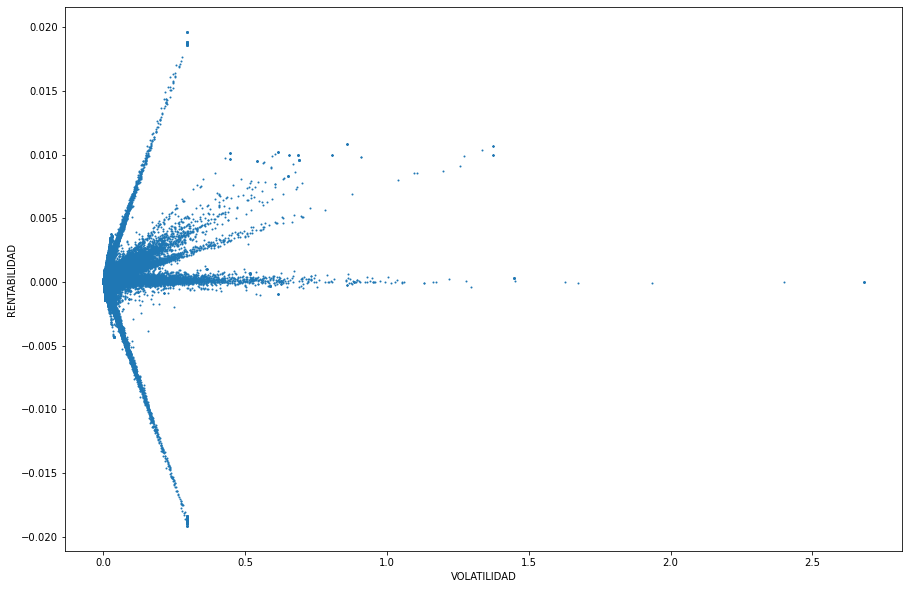

In [18]:
plt.figure(figsize=(15,10))
plt.scatter(risk, returns, s=1)
plt.xlabel('VOLATILIDAD')
plt.ylabel('RENTABILIDAD')
plt.savefig('frontera_markowitz.png')
plt.show()